* https://dacon.io/competitions/official/235713/codeshare/2498?page=1&dtype=recent
* https://dacon.io/competitions/official/235713/codeshare/2515?page=1&dtype=recent
* https://limjun92.github.io/assets/TensorFlow%202.0%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/8.%20%EA%B5%AC%EC%A1%B0%ED%99%94%EB%90%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0/%5B%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC1%5D%20%EC%A0%95%ED%98%95%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%8B%A4%EB%A3%A8%EA%B8%B0/

# 1. 라이브러리 불러오기

In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

# 2. 데이터 불러오기

In [119]:
data_path = 'C:/Users/USER/DACON/creditcard/'
train = pd.read_csv(data_path+'train.csv')
test = pd.read_csv(data_path+'test.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

# 3. 데이터 전처리

In [120]:
# data 준비
data = pd.concat([train, test], axis=0)

In [121]:
# index 제거
data = data.drop('index', axis=1, inplace=False)

In [122]:
# FLAG_MOBIL 제거
data = data.drop('FLAG_MOBIL', axis=1, inplace=False)

In [123]:
# occyp_type 제거
data = data.drop('occyp_type', axis=1, inplace=False)

In [124]:
# DAYS_BIRTH -> 년
def days_to_age(x): # 나이 변환
    return (x*-1)/365
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

In [125]:
# DAYS_EMPLOYED -> 년
data.loc[(data.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0 # 양수 값 변환
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)

In [126]:
# begin_month -> 개월
def minus(x): # 음수 값 변환
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)

In [127]:
# (family_size - child_num)가 음수인 경우 제거
data[(data['family_size']-data['child_num']).isin([0, -1])]
data = data.drop(index=[14900, 4918])

In [128]:
# family_size가 7 이상인 경우 처리
data.loc[data['family_size'] >= 7,'family_size'] = 7

In [129]:
# child_num이 2 이상인 경우 처리
data.loc[data['child_num'] >= 2,'child_num'] = 2

In [130]:
# # family_size 제거
# data = data.drop('family_size', axis=1, inplace=False)

In [131]:
# child_num 제거
data = data.drop('child_num', axis=1, inplace=False)

In [132]:
# income_total 로그변환
data['income_total'] = data['income_total'].apply(np.log)

In [133]:
# # income_total 타입 변환
# data['income_total'] = data['income_total'].astype(object)
# data['income_total'] = data['income_total']/10000 
# print(data['income_total'].value_counts(bins=10,sort=False))
# data['income_total'].plot(kind='hist',bins=50,density=True)

# count, bin_dividers =np.histogram(data['income_total'], bins=7)
# bin_names=[int(i) for i in range(7) ]
# data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [134]:
# Binary
data['gender'] = data['gender'].replace(['F','M'],[0,1])
data['car'] = data['car'].replace(['N','Y'],[0,1])
data['reality'] = data['reality'].replace(['N','Y'],[0,1])

In [135]:
# Categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['income_type'] = encoder.fit_transform(data['income_type'])
data['family_type'] = encoder.fit_transform(data['family_type'])
data['house_type'] = encoder.fit_transform(data['house_type'])

In [136]:
# Ordinal
order = {
    'Lower secondary' : 0, # 중학교 미만
    'Secondary / secondary special' : 1, # 중학교
    'Incomplete higher' : 2, # 고등학교 중퇴
    'Higher education' : 3, # 고등학교 졸업
     'Academic degree' : 4 # 학사 이상
}
data.edu_type = data['edu_type'].map(order)

In [137]:
# type 변환
data = data.astype({'DAYS_BIRTH': 'int'})
data = data.astype({'DAYS_EMPLOYED': 'int'})
data = data.astype({'begin_month': 'int'})

In [138]:
# train/test 분리
train = data[:len(data)-10000] 
test = data[len(data)-10000:]

In [139]:
# X/y 분리
train_X = train.drop('credit', axis=1)
train_y = train[['credit']]
test_X = test.drop('credit', axis=1)

In [140]:
# # 불균형데이터 처리
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter

# randomsample = RandomOverSampler()
# train_X, train_y = randomsample.fit_sample(train_X, train_y)

In [141]:
# train/val 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, stratify=train_y, test_size=0.25, random_state=2)

# 4. 모델링

In [142]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import sequence

## 모델(1)

In [195]:
model=Sequential()
model.add(Embedding(8000,64,input_length=35))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(3,activation='softmax'))
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 35, 64)            512000    
_________________________________________________________________
dropout_29 (Dropout)         (None, 35, 64)            0         
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 35, 512)           657408    
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 128)               295424    
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 387       
Total params: 1,465,219
Trainable params: 1,465,219
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
# 모델 compile option 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [197]:
# 모델 학습
history = model.fit(x=X_train, y=y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5
310/310 [==============================] - 91s 292ms/step - loss: 0.8846 - accuracy: 0.6394 - val_loss: 0.8666 - val_accuracy: 0.6423
Epoch 2/5
200/310 [==================>...........] - ETA: 28s - loss: 0.8704 - accuracy: 0.6435

KeyboardInterrupt: 

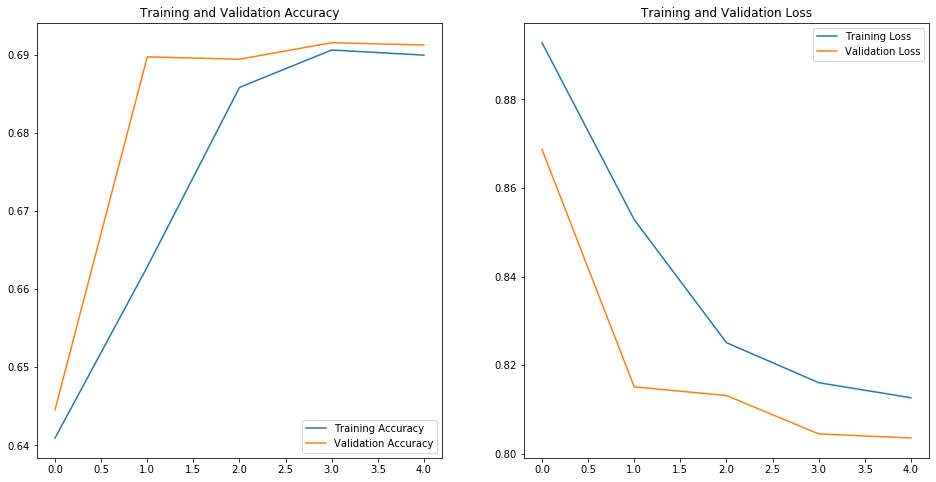

In [163]:
# 학습 결과
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 모델(2)

(2.0000000000000052e-05, 0.00106]      110
(0.00106, 0.0011]                      484
(0.0011, 0.00114]                     3894
(0.00114, 0.00118]                    9984
(0.00118, 0.00122]                   10707
(0.00122, 0.00126]                    7553
(0.00126, 0.0013]                     3186
(0.0013, 0.00135]                      417
(0.00135, 0.00139]                     102
(0.00139, 0.00143]                      17
Name: income_total, dtype: int64


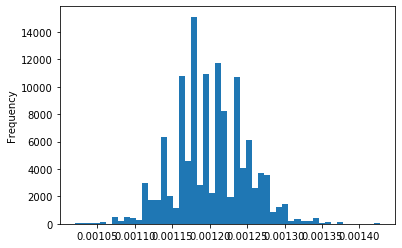

In [164]:
data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [49]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [50]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2)
print(len(train))
print(len(test))
print(len(val))

21163
10000
5291


In [51]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('credit')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [52]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [61]:
from tensorflow import feature_column
feature_columns = []

gender_type = feature_column.categorical_column_with_vocabulary_list(
      'gender', ['F','M'])
gender_type_one_hot = feature_column.indicator_column(gender_type)
feature_columns.append(gender_type_one_hot)


car_type = feature_column.categorical_column_with_vocabulary_list(
      'car',  ['N','Y'])
car_type_one_hot = feature_column.indicator_column(car_type)
feature_columns.append(car_type_one_hot)


reality_type = feature_column.categorical_column_with_vocabulary_list(
      'reality',  ['N','Y'])
reality_type_one_hot = feature_column.indicator_column(reality_type)
feature_columns.append(reality_type_one_hot)


phone_type = feature_column.categorical_column_with_vocabulary_list(
      'phone', [0, 1])
phone_type_one_hot = feature_column.indicator_column(phone_type)
feature_columns.append(phone_type_one_hot)


email_type = feature_column.categorical_column_with_vocabulary_list(
      'email', [0, 1])
email_type_one_hot = feature_column.indicator_column(email_type)
feature_columns.append(email_type_one_hot)


work_phone_type = feature_column.categorical_column_with_vocabulary_list(
      'work_phone', [0, 1])
work_phone_type_one_hot = feature_column.indicator_column(work_phone_type)
feature_columns.append(work_phone_type_one_hot)


income_total_type = feature_column.categorical_column_with_vocabulary_list(
      'income_total', [0, 1, 2, 3, 4, 5, 6])
income_total_type_one_hot = feature_column.indicator_column(income_total_type)
feature_columns.append(income_total_type_one_hot)


# child_num_type = feature_column.categorical_column_with_vocabulary_list(
#       'child_num', [0, 1, 2])
# child_num_type_one_hot = feature_column.indicator_column(child_num_type)
# feature_columns.append(child_num_type_one_hot)

income_type = feature_column.categorical_column_with_vocabulary_list(
      'income_type', ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student'])
income_type_one_hot = feature_column.indicator_column(income_type)
feature_columns.append(income_type_one_hot)


edu_type = feature_column.categorical_column_with_vocabulary_list(
      'edu_type', ['Higher education', 'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree'])
edu_type_one_hot = feature_column.indicator_column(edu_type)
feature_columns.append(edu_type_one_hot)


family_type = feature_column.categorical_column_with_vocabulary_list(
      'family_type', ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow'])
family_type_one_hot = feature_column.indicator_column(family_type)
feature_columns.append(family_type_one_hot)


house_type = feature_column.categorical_column_with_vocabulary_list(
      'house_type', ['Municipal apartment', 'House / apartment' 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment'])
house_type_one_hot = feature_column.indicator_column(house_type)
feature_columns.append(house_type_one_hot)

begin_month = feature_column.numeric_column("begin_month", dtype=tf.int32)
feature_columns.append(begin_month)


family_size = feature_column.numeric_column("family_size", dtype=tf.int32)
feature_columns.append(family_size)


DAYS_EMPLOYED = feature_column.numeric_column("DAYS_EMPLOYED", dtype=tf.int32)
feature_columns.append(DAYS_EMPLOYED)


DAYS_BIRTH = feature_column.numeric_column("DAYS_BIRTH", dtype=tf.int32)
feature_columns.append(DAYS_BIRTH)


begin_month_buckets = feature_column.bucketized_column(begin_month, boundaries=[0, 10, 20, 30, 40, 50, 60])
feature_columns.append(begin_month_buckets)


family_size_buckets = feature_column.bucketized_column(family_size, boundaries=[1, 4, 7, 10, 13, 16, 20])
feature_columns.append(family_size_buckets)


DAYS_EMPLOYED_buckets = feature_column.bucketized_column(DAYS_EMPLOYED, boundaries=[-1000, 0, 10, 20, 30, 40, 50])
feature_columns.append(DAYS_EMPLOYED_buckets)


DAYS_BIRTH_buckets = feature_column.bucketized_column(DAYS_BIRTH, boundaries=[20, 30, 40, 50, 60, 70])
feature_columns.append(DAYS_BIRTH_buckets)

In [62]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [63]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [64]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

662/662 [==============================] - 3s 5ms/step - loss: 1.8177e-07 - accuracy: 0.2121 - val_loss: 1.7864e-07 - val_accuracy: 0.2217
Epoch 2/5
662/662 [==============================] - 2s 3ms/step - loss: 1.8177e-07 - accuracy: 0.2121 - val_loss: 1.7864e-07 - val_accuracy: 0.2217
Epoch 3/5
662/662 [==============================] - 2s 4ms/step - loss: 1.8177e-07 - accuracy: 0.2121 - val_loss: 1.7864e-07 - val_accuracy: 0.2217
Epoch 4/5
662/662 [==============================] - 2s 3ms/s

# 5. 제출

In [165]:
from sklearn.metrics import log_loss

In [166]:
# for validation
y_proba = model.predict_proba(X_val) # 예측확률
y_val_onehot = pd.get_dummies(y_val) # 예측값
log_loss(y_val_onehot, y_proba) # logloss

0.8035598796301462

In [167]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] = model.predict_proba(test_X)
submission.to_csv("_sub_08.csv", index=False)
submission.head()

,index,0,1,2
0,26457,0.102007,0.229891,0.668103
1,26458,0.081048,0.153882,0.765069
2,26459,0.120417,0.156082,0.723501
3,26460,0.113244,0.215081,0.671675
4,26461,0.123762,0.165127,0.711111
